# Import Libraries

In [1]:
# For data processing
import pandas as pd
import numpy as np

# For interactive plots
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# For extracting environment variables
import os

# To reference specific dates when scraping for stock prices
import datetime
from dateutil.relativedelta import relativedelta

# For parsing financial data from Financial Modeling Prep API base url
from urllib.request import urlopen
import json
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Set Up API Key for FMP Endpoint
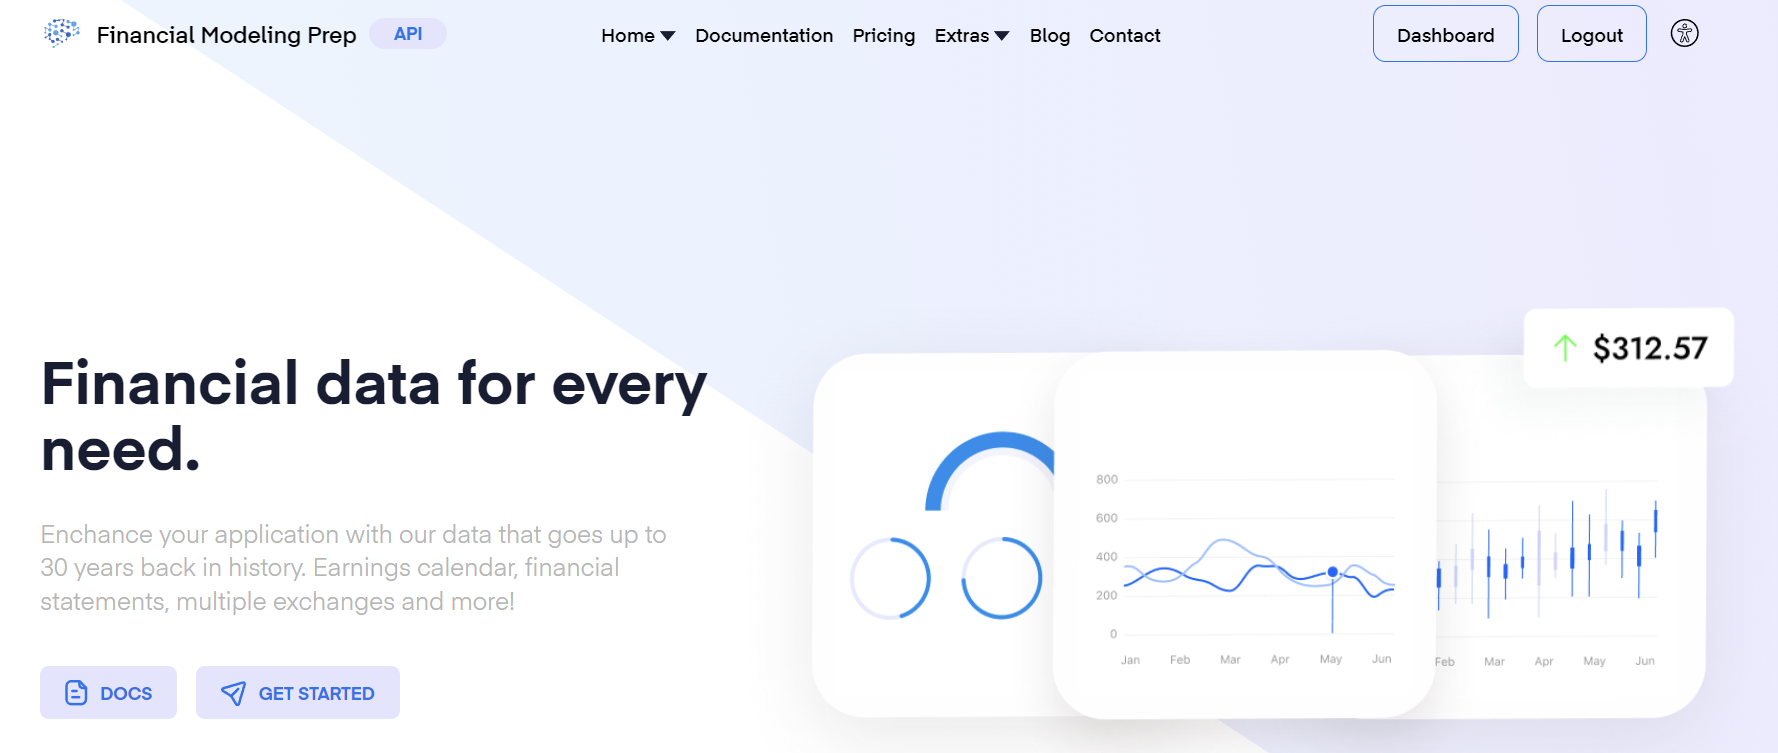

The Financial Modeling Prep (FMP) API is an accurate financial data (i.e. stocks, earnings, historical data, market sentiment, financial statements etc.) API. You need to obtain the Financial Modeling Prep (FMP) API key (sign up [here](https://intelligence.financialmodelingprep.com/pricing-plans?couponCode=damianboh&utm_campaign=damianboh&utm_medium=blog&utm_source=medium)). 

There is a free version where you can get 250 calls per day for free, which is more than enough to track a decently large portfolio multiple times daily and run the steps below.

In [2]:
# Financial Modeling Prep API base url
base_url = "https://financialmodelingprep.com/api/v3/"

# os.environ['FMP_API_KEY'] = 'your_api_key'
apikey = os.environ['FMP_API_KEY']

# Enter Tickers and Number of Stocks in a Dictionary Here

In [3]:
portfolio = {
    "AAPL":8, # "ticker symbol": number of shares owned
    "TSLA":3,
    "META":3,
    "GOOG":5,
    "NVDA":6,
    "VEEV":3,
    "HCA":4,
    "AIY.SI":450,
    "D05.SI":100, # ticker can be for Singapore stocks too
    "U11.SI":130,
    "9988.HK":60, # ticker can be for Hong Kong stocks too
    "9618.HK":80,
    "MPNGY": 80, # can be China stock listed in US too
    "JNJ": 25,
    "MMM": 20,
    "HON": 10,
    "MCD": 10,
    "YUM": 10
}

# Get Company Profile Data for All Your Tickers
This FMP API endpoint https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey={apikey} allows you to get the full company profile (current price and currency, which sector, country it is in, company name etc.).

### Get Foreign Exchange Rates if Price is Not in USD
To compare each stock you own relative to other stocks in your portfolio later, you will need to use the same currency. Some of the stocks may be in other currencies so we need the exchange rate to convert them to USD. FMP offers an endpoint for that too, shown in the code as https://financialmodelingprep.com/api/v3/fx/{currency}USD?apikey={apikey}.

In [4]:
profiles = [] # list to save all the company profiles data
for ticker, n_shares in portfolio.items():
  ticker = ticker.upper() # make sure ticker is caps
  print("Getting profile for", ticker)
  url = f"{base_url}profile/{ticker}?apikey={apikey}" # get company profile information
  profile = get_jsonparsed_data(url)[0]
  profile["No. Shares"] = n_shares # number of stocks in your portfolio in your input earlier
  currency = profile["currency"] # if this is not USD, this can be input into the FMP API endpoint below to get forex rates

  # get real time forex data if currency is not already in USD
  # so we can compare the stocks' allocation in portfolio equally
  if currency != "USD":
      # FMP endpoint for getting forex rate
      fx_url = f"{base_url}fx/{currency}USD?apikey={apikey}" # get exchange rate
      exchange_rate = float(get_jsonparsed_data(fx_url)[0]['ask'])
      profile['Exchange Rate'] = exchange_rate
  else:
      profile['Exchange Rate'] = 1 # price is already in USD

  profiles.append(profile)

Getting profile for AAPL
Getting profile for TSLA
Getting profile for META
Getting profile for GOOG
Getting profile for NVDA
Getting profile for VEEV
Getting profile for HCA
Getting profile for AIY.SI
Getting profile for D05.SI
Getting profile for U11.SI
Getting profile for 9988.HK
Getting profile for 9618.HK
Getting profile for MPNGY
Getting profile for JNJ
Getting profile for MMM
Getting profile for HON
Getting profile for MCD
Getting profile for YUM


# Save Company Profiles in DataFrame and Convert Stock Price to USD
Save the scraped company profiles in a Pandas DataFrame and also calculate the price of each stock in USD (using the exchange rate). We also calculate the total value each stock in the portfolio by multiplying by number of shares owned.

In [5]:
df_profiles = pd.DataFrame(profiles)
df_profiles["Price USD"] = df_profiles["price"]*df_profiles["Exchange Rate"]
df_profiles["Portfolio Value USD"] = df_profiles["Price USD"]*df_profiles["No. Shares"]
df_profiles.head()

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,ipoDate,defaultImage,isEtf,isActivelyTrading,isAdr,isFund,No. Shares,Exchange Rate,Price USD,Portfolio Value USD
0,AAPL,189.69,1.308,58857157,2950210583439,0.96,124.17-198.23,-0.02,Apple Inc.,USD,...,1980-12-12,False,False,True,False,False,8,1.0,189.69,1517.52
1,TSLA,234.30,2.281,121400554,744820941005,0.00,101.81-299.29,0.71,"Tesla, Inc.",USD,...,2010-06-29,False,False,True,False,False,3,1.0,234.30,702.90
2,META,335.04,1.206,20589407,861005885019,0.00,108.32-338.4,0.85,"Meta Platforms, Inc.",USD,...,2012-05-18,False,False,True,False,False,3,1.0,335.04,1005.12
3,GOOG,136.94,1.050,21244125,1705450728641,0.00,85.57-142.38,-1.76,Alphabet Inc.,USD,...,2004-08-19,False,False,True,False,False,5,1.0,136.94,684.70
4,NVDA,492.98,1.684,48342781,1217660663101,0.16,138.84-502.66,-1.82,NVIDIA Corporation,USD,...,1999-01-22,False,False,True,False,False,6,1.0,492.98,2957.88


# Get Dates of Interest for Stock Price Scraping
You likely may want to track the performance of your stocks for certain time periods, such as 1 Day, 1 Month, 3 Month, 6 Month, Year to Date and 1 Year Performance which I have included below. We will look out for these dates in scraping the stock prices later, I have also converted the dates to strings format. Feel free to change it to include other dates of interest.

In [6]:
today = datetime.datetime.today() # get today's date
string_today = today.strftime('%Y-%m-%d') # convert to string

# get other dates of interest by subtracting the corresponding amount of days/months/years from today
string_1_year = (today - relativedelta(years=1)).strftime('%Y-%m-%d')
string_1_month = (today - relativedelta(months=1)).strftime('%Y-%m-%d')
string_3_month = (today - relativedelta(months=3)).strftime('%Y-%m-%d')
string_6_month = (today - relativedelta(months=6)).strftime('%Y-%m-%d')
string_1_week = (today - relativedelta(days=7)).strftime('%Y-%m-%d')
string_ytd = datetime.datetime(today.year, 1, 1).strftime('%Y-%m-%d')


# store interested prices in dictonary
interested_prices_dates = {
    '1 Year': string_1_year,
    'Year to Date': string_ytd,
    '1 Month': string_1_month,
    '3 Month': string_3_month,
    '6 Month': string_6_month,
    '1 Week': string_1_week
}

earliest_date_string = string_1_year # this is the earliest date from which to scrape prices, needed as input to FMP API later

interested_prices_dates

{'1 Year': '2022-11-19',
 'Year to Date': '2023-01-01',
 '1 Month': '2023-10-19',
 '3 Month': '2023-08-19',
 '6 Month': '2023-05-19',
 '1 Week': '2023-11-12'}

# Scrape the Stock Prices for All Dates of Interest

In [7]:
all_prices = {} # to store all price data of all tickers
prices_of_interest = [] # to store price data of all tickers for dates of interest
for ticker, n_stocks in portfolio.items():
    print("Scraping stock prices for", ticker)
    prices = {} # to store price data of each ticker
    prices['symbol'] = ticker

    # FMP API to get historical stock prices from the earliest interested date
    price_url = f"{base_url}historical-price-full/{ticker}?from={earliest_date_string}&apikey={apikey}"
    # call the API just once to get all prices, then extract prices for the interested dates below
    historical_prices = get_jsonparsed_data(price_url)['historical']
    df_historical_prices = pd.DataFrame(historical_prices).set_index('date') # turn DataFrame in time series by setting index to be the date column
    all_prices[ticker] = df_historical_prices
    # iloc[1] locates 2nd row, which is previous closing price, current day close is already in 'price' column pulled earlier
    prices['1 Day'] = df_historical_prices.iloc[1]['adjClose']  # price 1 day ago

    # etract prices for interestested dates
    for label, date_string in interested_prices_dates.items():
        # why do we use .truncate() below?
        # if our date of interest is not inside the dataframe (i.e. it is a public holiday or non working day)
        # the truncate function help us to locate the first date that occurs after our date of interest
        prices[label] = df_historical_prices.truncate(before=date_string).iloc[-1]['adjClose']

    prices_of_interest.append(prices)



Scraping stock prices for AAPL
Scraping stock prices for TSLA
Scraping stock prices for META
Scraping stock prices for GOOG
Scraping stock prices for NVDA
Scraping stock prices for VEEV
Scraping stock prices for HCA
Scraping stock prices for AIY.SI
Scraping stock prices for D05.SI
Scraping stock prices for U11.SI
Scraping stock prices for 9988.HK
Scraping stock prices for 9618.HK
Scraping stock prices for MPNGY
Scraping stock prices for JNJ
Scraping stock prices for MMM
Scraping stock prices for HON
Scraping stock prices for MCD
Scraping stock prices for YUM


# Store the Prices in a DataFrame

In [8]:
df_prices = pd.DataFrame(prices_of_interest)
df_prices

,symbol,1 Day,1 Year,Year to Date,1 Month,3 Month,6 Month,1 Week
0,AAPL,189.71,147.190000,124.370000,175.23,175.61,174.690000,184.80
1,TSLA,233.59,167.870000,108.100000,220.11,231.28,180.140000,223.71
2,META,334.19,109.860000,124.740000,312.81,289.90,245.640000,329.19
3,GOOG,138.70,95.830000,89.700000,138.98,128.93,123.250000,133.64
4,NVDA,494.80,153.080000,143.100000,421.01,469.63,312.580000,486.20
5,VEEV,175.32,181.679993,159.619995,202.17,188.06,165.350006,166.25
6,HCA,240.42,226.910000,241.550000,244.05,274.19,281.230000,229.99
7,AIY.SI,7.73,4.650000,5.760000,5.59,5.49,4.280000,7.46
8,D05.SI,32.64,33.790000,32.470000,33.17,32.52,30.400000,32.60
9,U11.SI,27.42,28.422365,29.830000,27.88,27.78,27.095013,27.32


# Merge the DataFrames of Company Profiles and Stock Prices Together

In [9]:
df = df_profiles.merge(df_prices, left_on='symbol', right_on='symbol', how = 'left')
df.head()

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,Exchange Rate,Price USD,Portfolio Value USD,1 Day,1 Year,Year to Date,1 Month,3 Month,6 Month,1 Week
0,AAPL,189.69,1.308,58857157,2950210583439,0.96,124.17-198.23,-0.02,Apple Inc.,USD,...,1.0,189.69,1517.52,189.71,147.19,124.37,175.23,175.61,174.69,184.80
1,TSLA,234.30,2.281,121400554,744820941005,0.00,101.81-299.29,0.71,"Tesla, Inc.",USD,...,1.0,234.30,702.90,233.59,167.87,108.10,220.11,231.28,180.14,223.71
2,META,335.04,1.206,20589407,861005885019,0.00,108.32-338.4,0.85,"Meta Platforms, Inc.",USD,...,1.0,335.04,1005.12,334.19,109.86,124.74,312.81,289.90,245.64,329.19
3,GOOG,136.94,1.050,21244125,1705450728641,0.00,85.57-142.38,-1.76,Alphabet Inc.,USD,...,1.0,136.94,684.70,138.70,95.83,89.70,138.98,128.93,123.25,133.64
4,NVDA,492.98,1.684,48342781,1217660663101,0.16,138.84-502.66,-1.82,NVIDIA Corporation,USD,...,1.0,492.98,2957.88,494.80,153.08,143.10,421.01,469.63,312.58,486.20


# Calculate Stock Price Performance Over Different Periods of Time

For each of the different interested dates in each column, calculate total portfolio value in USD for each stock. This is used for performance measures later.

In [10]:
# For each of the different interested dates in each column, calculate total portfolio value in USD for each stock
# For performance measures later
past_prices_columns = list(interested_prices_dates.keys()) + ["1 Day"]
print(past_prices_columns)

for col in past_prices_columns:
  df[f"{col} Total USD"] = df[col] * df["Exchange Rate"] * df["No. Shares"]

df.head()

['1 Year', 'Year to Date', '1 Month', '3 Month', '6 Month', '1 Week', '1 Day']


,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,3 Month,6 Month,1 Week,1 Year Total USD,Year to Date Total USD,1 Month Total USD,3 Month Total USD,6 Month Total USD,1 Week Total USD,1 Day Total USD
0,AAPL,189.69,1.308,58857157,2950210583439,0.96,124.17-198.23,-0.02,Apple Inc.,USD,...,175.61,174.69,184.80,1177.52,994.96,1401.84,1404.88,1397.52,1478.40,1517.68
1,TSLA,234.30,2.281,121400554,744820941005,0.00,101.81-299.29,0.71,"Tesla, Inc.",USD,...,231.28,180.14,223.71,503.61,324.30,660.33,693.84,540.42,671.13,700.77
2,META,335.04,1.206,20589407,861005885019,0.00,108.32-338.4,0.85,"Meta Platforms, Inc.",USD,...,289.90,245.64,329.19,329.58,374.22,938.43,869.70,736.92,987.57,1002.57
3,GOOG,136.94,1.050,21244125,1705450728641,0.00,85.57-142.38,-1.76,Alphabet Inc.,USD,...,128.93,123.25,133.64,479.15,448.50,694.90,644.65,616.25,668.20,693.50
4,NVDA,492.98,1.684,48342781,1217660663101,0.16,138.84-502.66,-1.82,NVIDIA Corporation,USD,...,469.63,312.58,486.20,918.48,858.60,2526.06,2817.78,1875.48,2917.20,2968.80


### Calculate the performance as percentage change in price over the time period.

In [11]:
# Calculate Performance for each Period of Time
# Store them in columns with names like "1 Day Performance", "1 Year Performance etc."
for col in past_prices_columns:
   df[f"{col} Performance"] = (df["Portfolio Value USD"]/df[f"{col} Total USD"] - 1)*100
df.head()

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,6 Month Total USD,1 Week Total USD,1 Day Total USD,1 Year Performance,Year to Date Performance,1 Month Performance,3 Month Performance,6 Month Performance,1 Week Performance,1 Day Performance
0,AAPL,189.69,1.308,58857157,2950210583439,0.96,124.17-198.23,-0.02,Apple Inc.,USD,...,1397.52,1478.40,1517.68,28.874244,52.520704,8.252012,8.017767,8.586639,2.646104,-0.010542
1,TSLA,234.30,2.281,121400554,744820941005,0.00,101.81-299.29,0.71,"Tesla, Inc.",USD,...,540.42,671.13,700.77,39.572288,116.743756,6.446777,1.305777,30.065505,4.733807,0.303951
2,META,335.04,1.206,20589407,861005885019,0.00,108.32-338.4,0.85,"Meta Platforms, Inc.",USD,...,736.92,987.57,1002.57,204.969962,168.590669,7.106550,15.570887,36.394724,1.777089,0.254346
3,GOOG,136.94,1.050,21244125,1705450728641,0.00,85.57-142.38,-1.76,Alphabet Inc.,USD,...,616.25,668.20,693.50,42.898883,52.664437,-1.467837,6.212674,11.107505,2.469321,-1.268926
4,NVDA,492.98,1.684,48342781,1217660663101,0.16,138.84-502.66,-1.82,NVIDIA Corporation,USD,...,1875.48,2917.20,2968.80,222.040763,244.500349,17.094606,4.971999,57.713225,1.394488,-0.367825


# Rename Columns to Better Display Them in the Heatmap Later

In [12]:
cols_rename = {
    'symbol':'Symbol',
    'price':'Current Price',
    'currency': 'Currency',
    'n_stocks': 'No. of Shares',
    'sector': 'Sector',
    'country': 'Country',
    'companyName': 'Company Name',
}
df = df.rename(columns=cols_rename)
df = df.round(2)
df.head()

,Symbol,Current Price,beta,volAvg,mktCap,lastDiv,range,changes,Company Name,Currency,...,6 Month Total USD,1 Week Total USD,1 Day Total USD,1 Year Performance,Year to Date Performance,1 Month Performance,3 Month Performance,6 Month Performance,1 Week Performance,1 Day Performance
0,AAPL,189.69,1.31,58857157,2950210583439,0.96,124.17-198.23,-0.02,Apple Inc.,USD,...,1397.52,1478.40,1517.68,28.87,52.52,8.25,8.02,8.59,2.65,-0.01
1,TSLA,234.30,2.28,121400554,744820941005,0.00,101.81-299.29,0.71,"Tesla, Inc.",USD,...,540.42,671.13,700.77,39.57,116.74,6.45,1.31,30.07,4.73,0.30
2,META,335.04,1.21,20589407,861005885019,0.00,108.32-338.4,0.85,"Meta Platforms, Inc.",USD,...,736.92,987.57,1002.57,204.97,168.59,7.11,15.57,36.39,1.78,0.25
3,GOOG,136.94,1.05,21244125,1705450728641,0.00,85.57-142.38,-1.76,Alphabet Inc.,USD,...,616.25,668.20,693.50,42.90,52.66,-1.47,6.21,11.11,2.47,-1.27
4,NVDA,492.98,1.68,48342781,1217660663101,0.16,138.84-502.66,-1.82,NVIDIA Corporation,USD,...,1875.48,2917.20,2968.80,222.04,244.50,17.09,4.97,57.71,1.39,-0.37


# Function to Generate Your Heatmap (or more appropriately, treemap)!

In [78]:
def generate_treemap(performance_to_track):
    range_color_value = df[performance_to_track].max()/2 # for range in color scale below, this seems to give nice shades of green and red

    fig = px.treemap(df,
                        # path parameter below means heatmap will first break portfolio up by Country, then Sector, then Symbol of each company (in that order)
                        path=[px.Constant(f"My Personal Portfolio {performance_to_track}"),'Country', 'Sector', 'Symbol'],
                        # values parameter is for stating what the size of each box in heatmap represents
                        # in this case we represent the total portfolio value of each stock in USD with the size
                        # larger portfolio allocation to the stock will result in a large size,
                        values='Portfolio Value USD',
                        hover_data=['Company Name', 'Current Price', 'Currency', 'No. Shares'], # what to show when hovering over each box in heatmap
                        color=performance_to_track, # color will represent the performance measure (i.e. change in stock price over a specific time period)
                        range_color=[-range_color_value,range_color_value], # range of values for which the color scale below will apply
                        color_continuous_scale=['#FF0000',"#000000", '#00FF00'], # red for values below 0, black for 0, green for high values
                        color_continuous_midpoint=0 # midpoint will be 0, i.e. 0% change in price
                    )

    fig.update_traces(textposition="middle center", # by default the text in each box is at the top left, we change this to center
                      selector=dict(type='treemap'),
                          marker_line_width = 4)

    fig.update_layout(margin = dict(t=30, l=10, r=10, b=10), height=550, font_size=16) # add some margins and change font size to make it look nicer

    # by default, only the label (Symbol) will be shown, customdata[4] stores the performance measure of the stock, i.e. change in stock price
    fig.data[0].texttemplate = "%{label}<br><br>%{customdata[4]:.2f}%"

    return fig

# Heatmap for 1 Day Performance

In [79]:
fig1 = generate_treemap('1 Day Performance')
fig1.show()

# Heatmap for 1 Week Performance

In [80]:
fig2 = generate_treemap('1 Week Performance')
fig2.show()

# Heatmap for 1 Month Performance

In [81]:
fig3 = generate_treemap('1 Month Performance')
fig3.show()

# Heatmap for 3 Month Performance

In [82]:
fig4 = generate_treemap('3 Month Performance')
fig4.show()

# Heatmap for 6 Month Performance

In [83]:
fig5 = generate_treemap('6 Month Performance')
fig5.show()

# Heatmap for 1 Year Performance

In [84]:
fig6 = generate_treemap('1 Year Performance')
fig6.show()

# Heatmap for Year To Date Performance

In [85]:
fig7 = generate_treemap('Year to Date Performance')
fig7.show()

# Optional: Generate HTML File for All 4 Heatmaps Above

In [77]:
# Generate HTML File with Updated Time and Treemap
with open('stock_portfolio_performance_heatmaps.html', 'a') as f:
    f.truncate(0) # clear file if something is already written on it
    title = "<h1>Stock Portfolio Performance Heatmaps for Different Time Periods</h1>"
    code = """<a href="https://medium.com/p/3588555a5ac8/">Explanatory Article</a> | <a href="https://github.com/damianboh/stock_portfolio_performance_heatmap">Source Code</a>"""
    author = """ | Created by Damian Boh, check out my <a href="https://damianboh.github.io/">GitHub Page</a>"""
    f.write(title + code + author)
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file
    f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file
    f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file
    f.write(fig6.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file
    f.write(fig7.to_html(full_html=False, include_plotlyjs='cdn')) # write the fig created above into the html file

    